<a href="https://colab.research.google.com/github/DanielDes/PracticasPLN/blob/master/Practica2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica 2

De San Pedro Vázquez Luis Daniel

In [0]:
from google.colab import files
import io


def upload_corpus():
  
  uploaded_files = files.upload()
  key = list(uploaded_files.keys())[0]
  corpus = uploaded_files[key].decode('utf8')

  return corpus

Subimos el archivo del corpus y lo procesamos, donde quitamos signos puntuación, de exclamación y de admiración. Conservamos los acentos de las palabras. Mientras hacemos la iteración, aprovechamos para agregar los símbolos de inicio y fin de cadena, que serán '+' '-' respectivamente.

In [5]:
import re
def remove_symbols(word):
  word = word.lower()
  if re.match('^[^ a-z A-Z]',word):
    word = word[1:]
  if re.match('[a-z A-Z]*[^ a-z A-Z á é í ó ú]$', word):
    word = word[:-1]
  return word

def prepare_corpus(corpus):
  corpus = list( list(map(remove_symbols,sentence.split(' '))) for sentence in corpus.split('\n'))
  for sentence in corpus:
    if len(sentence) == 1:
      corpus.remove(sentence)
      break
    sentence.insert(0,'+')
    sentence.append('-')
  return corpus

corpus = upload_corpus()
clean_corpus = prepare_corpus(corpus)


Saving corpusML.txt to corpusML.txt


Preparamos un diccionario con los índices de cada palabra que encontramos en el corpus. 

In [6]:
def prepare_hashmap(corpus):
  index = 0
  hashmap = {}
  for sentence in corpus:
    for word in sentence:
      try:
        value = hashmap[word]
      except KeyError:
        hashmap[word] = index
        index += 1
  return hashmap 

hashmap = prepare_hashmap(clean_corpus)
print(hashmap)

{'+': 0, 'comencé': 1, 'a': 2, 'trabajar': 3, 'y': 4, 'me': 5, 'pegaron': 6, 'maltrataron': 7, 'con': 8, 'chicote': 9, '': 10, '-': 11, 'mis': 12, 'patrones': 13, 'porque': 14, 'no': 15, 'quería': 16, 'apurar': 17, 'era': 18, 'flojo': 19, 'por': 20, 'eso': 21, 'habían': 22, 'pegado': 23, 'cuando': 24, 'pegaban': 25, 'ya': 26, 'entonces': 27, 'quitaba': 28, 'pues': 29, 'quise': 30, 'estar': 31, 'como': 32, 'después': 33, 'estuve': 34, 'nomás': 35, 'en': 36, 'mi': 37, 'casa': 38, 'fui': 39, 'juntar': 40, 'caca': 41, 'de': 42, 'caballo': 43, 'caquitas': 44, 'se': 45, 'aventaron': 46, 'las': 47, 'culebras': 48, 'los': 49, 'animales': 50, 'pero': 51, 'aventaban': 52, 'víboras': 53, 'muy': 54, 'grandes': 55, 'asusté': 56, 'que': 57, 'luego': 58, 'otra': 59, 'vez': 60, 'nomás,': 61, 'entré': 62, 'la': 63, 'escuela': 64, 'hallé': 65, 'supe': 66, 'nada': 67, 'sacaron': 68, 'sacó': 69, 'padre': 70, 'madre': 71, 'pobrecita': 72, 'tenía': 73, 'necesidad': 74, 'así': 75, 'sufrí': 76, 'allí': 77, 'h

Observamos el número de palabras diferentes que encontramos en el corpus.

In [7]:
vector_size = len(hashmap)
print(vector_size)

1763


Definimos la clase de la red neuronal. Donde en el constructor definimos las dimensiones de las capas de embedings, la capa oculta. Tambien le proporcionaremos a la red el diccionario y el corpus.

In [0]:
import numpy as np
from scipy.special import softmax
from math import exp

class LanguageNeuralNetwork:
  
  def __init__(self,embedding_d,hidden_d,word_indexes,corpus):
    self.embedding_d = embedding_d 
    self.hidden_d = hidden_d
    self.word_indexes = word_indexes
    self.corpus = corpus
    self.vector_size = len(word_indexes)


  
  def split_into_bigrams(self,corpus=None,get_words=False):
    bigrams = []
    word_bigrams = []
    corpus_sample = ""

    if corpus is None:
      corpus_sample = self.corpus
    else : 
      corpus_sample = corpus


    for sentence in corpus_sample:
        n_word = len(sentence)
        for index in range(0,n_word - 1 ):
          
          first_w_index = self.word_indexes[sentence[index]]
          sec_w_index = self.word_indexes[sentence[index + 1]]

          bigrams.append([first_w_index,
                               sec_w_index
                          ])
          word_bigrams.append([sentence[index],
                               sentence[index + 1]
                               ])
    
    if get_words:
      return bigrams,word_bigrams
    
    return bigrams

  def feed_forward(self, X, Y):

    self.Cx = np.reshape(np.dot(self.C,X), 
                         (self.embedding_d,1))      # Capa 1

    pre_h = np.dot(self.W, self.Cx) + self.b        # Capa 2

    self.H =  np.tanh(pre_h)                       #Activacion por tangh

    pre_a = np.dot(self.U,self.H) + self.c         # Capa 3 

    P = softmax(pre_a)                              # Activación por softmax

    return P
  
  def back_propagation(self,P,Y,X,alpha):

    c = np.reshape(self.Cx, (len(self.Cx),1))
    h = np.reshape(self.H, (len(self.H),1))
    in_vector = np.reshape(X, (len(X),1))
    p = np.reshape(P , ( len(P), 1))
    y = np.reshape(Y , (len (Y), 1))

    # Calculamos las afinidades de capa 
    D_out = p - y
    D_h = (1 - h ** 2 ) * np.dot(self.U.T,D_out)
    D_c = np.dot(self.W.T, D_h)

    # Actializamos los vectores de pesos de cada capa
    self.U = self.U - alpha * np.dot(D_out, h.T)
    self.W = self.W - alpha * np.dot(D_h,c.T)
    self.C = self.C - alpha * np.dot(D_c, in_vector.T)

    # Actualizamos los vectores de bias
    self.b = self.b - alpha * D_h
    self.c = self.c - alpha * D_out

  def predict_string(self, string):
    print("---------- Predicting ------------")
    print("{}".format(string))
    try:
      bigrams,w_bigrams = self.split_into_bigrams(string,True)
    except KeyError as error:
      print("P = 0")
      print('La palabra \'{}\' no esta presente en el corpus original.'.format(error.args[0]))
      return
    probability_in_general = 1

    for index,bigram in enumerate(bigrams):
        #Obtenenemos los índices de las palabras en el bigrama
        x_index = bigram[0]
        y_index = bigram[1]
        #Creamos los vectores one-hot
        X = np.zeros(self.vector_size)
        Y = np.zeros(self.vector_size)
        X[x_index] = 1 
        Y[y_index] = 1

        P = self.feed_forward(X,Y)
        bigram_P =P[y_index][0]


        probability_in_general *= bigram_P
        print('{} \t P = {}'.format(w_bigrams[index],bigram_P))

    print('P = {:.2E}'.format(probability_in_general))

          
  def train(self, epochs, alpha ):
    bigrams = self.split_into_bigrams()
    #Inicializamos los vectores de pesos con valores aleatorios
    self.C = np.random.rand(self.embedding_d, self.vector_size)   # Pesos de la capa de embedding
    self.W = np.random.rand(self.hidden_d, self.embedding_d)      # Pesos de la capa oculta
    self.U = np.random.rand(self.vector_size, self.hidden_d)      # Pesos de la capa de salida
    #Inicializamos los vectores de bias con valores aleatorios.
    self.b = np.random.rand(self.hidden_d,1)
    self.c = np.random.rand(self.vector_size,1)
    history = []
    for epoch in range(1,epochs):
      cross_entropy = 0
      for bigram in bigrams:
        #Obtenenemos los índices de las palabras en el bigrama
        x_index = bigram[0]
        y_index = bigram[1]
        #Creamos los vectores one-hot
        X = np.zeros(self.vector_size)
        Y = np.zeros(self.vector_size)
        X[x_index] = 1 
        Y[y_index] = 1

        #Hacemos el feed forwar y obtenemos las probabilidades de cada bigrama
        P = self.feed_forward(X,Y)
        
        
        #Aplicamos backpropagation para resolver el problema de optimización
        self.back_propagation(P,Y,X,alpha)


        #Calculamos la entropía curzada de esta iteración.
        loged =np.log(P)
        cross_entropy += -loged[y_index][0]
                          
      
      cross_entropy = cross_entropy / self.vector_size
      history.append(cross_entropy)
      print(" Epoch {} - > Cross Entropy = {:.2f}".format(epoch,cross_entropy))
    
    #Retornamo todo el historial de entropias 
    return  history
    


Para realizar pruebas definimos los siguientes hiperparámetros.

In [9]:
embeding = 4 
hidden = 10
epochs = 100
alpha = 0.1


neural_language = LanguageNeuralNetwork(embeding,hidden,hashmap,clean_corpus)
history = neural_language.train(epochs,alpha)

 Epoch 1 - > Cross Entropy = 31.07
 Epoch 2 - > Cross Entropy = 28.32
 Epoch 3 - > Cross Entropy = 27.01
 Epoch 4 - > Cross Entropy = 26.06
 Epoch 5 - > Cross Entropy = 25.30
 Epoch 6 - > Cross Entropy = 24.76
 Epoch 7 - > Cross Entropy = 24.36
 Epoch 8 - > Cross Entropy = 24.07
 Epoch 9 - > Cross Entropy = 23.85
 Epoch 10 - > Cross Entropy = 23.75
 Epoch 11 - > Cross Entropy = 23.53
 Epoch 12 - > Cross Entropy = 23.33
 Epoch 13 - > Cross Entropy = 23.15
 Epoch 14 - > Cross Entropy = 23.11
 Epoch 15 - > Cross Entropy = 22.95
 Epoch 16 - > Cross Entropy = 22.96
 Epoch 17 - > Cross Entropy = 22.76
 Epoch 18 - > Cross Entropy = 22.75
 Epoch 19 - > Cross Entropy = 22.68
 Epoch 20 - > Cross Entropy = 22.63
 Epoch 21 - > Cross Entropy = 22.62
 Epoch 22 - > Cross Entropy = 22.68
 Epoch 23 - > Cross Entropy = 22.71
 Epoch 24 - > Cross Entropy = 22.54
 Epoch 25 - > Cross Entropy = 22.34
 Epoch 26 - > Cross Entropy = 22.43
 Epoch 27 - > Cross Entropy = 22.25
 Epoch 28 - > Cross Entropy = 22.25
 

Realizamos una prueba con las siguientes cadenas.

In [10]:
t = prepare_corpus('Nos bañamos con agua caliente')
t2 = prepare_corpus('El animalito olía la cabeza')
t3 = prepare_corpus('Pascuala ordeñaba las vacas')

neural_language.predict_string(t)
neural_language.predict_string(t2)
neural_language.predict_string(t3)


---------- Predicting ------------
[['+', 'nos', 'bañamos', 'con', 'agua', 'caliente', '-']]
P = 0
La palabra 'caliente' no esta presente en el corpus original.
---------- Predicting ------------
[['+', 'el', 'animalito', 'olía', 'la', 'cabeza', '-']]
['+', 'el'] 	 P = 0.020318334110650614
['el', 'animalito'] 	 P = 0.021267466386422386
['animalito', 'olía'] 	 P = 1.735912580933176e-10
['olía', 'la'] 	 P = 0.4776263272651118
['la', 'cabeza'] 	 P = 0.04157368185755019
['cabeza', '-'] 	 P = 3.5412857945943e-10
P = 5.27E-25
---------- Predicting ------------
[['+', 'pascuala', 'ordeñaba', 'las', 'vacas', '-']]
['+', 'pascuala'] 	 P = 4.576909633882062e-05
['pascuala', 'ordeñaba'] 	 P = 9.116513802235513e-08
['ordeñaba', 'las'] 	 P = 0.3755591617219156
['las', 'vacas'] 	 P = 0.08814445139020483
['vacas', '-'] 	 P = 4.956115214303181e-19
P = 6.85E-32


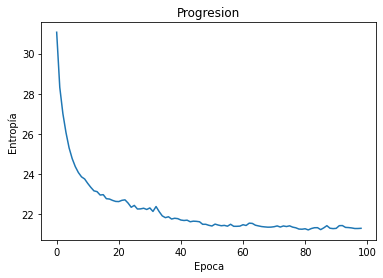

In [11]:
import matplotlib.pyplot as plt

figure = plt.subplot(111)
figure.set_title('Progresion')
figure.set_ylabel('Entropía')
figure.set_xlabel('Epoca')
figure.plot(np.arange(0,len(history)), history )

plt.show()

## Conclusiones
Finalmente se logró implementar la arquitectura que presentó [Bengio et al (2003)](http://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf). Por un lado durante el entrenamiento se puede observar que la entropía de la red neuronal poco a poco baja, esto producto de la implementación del algoritmo de *back propagation*, que se encarga de resolver el problema de optimización por medio de descenso de gradiente. 


## Bibliografia
Bengio et al (2003) A Neural Probabilistic Language Model

Rumelhart et al (1986) Learning representations by back-propagating errors